### Librerias

In [1]:
import tqdm

In [2]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
import copy
import EDAspy2
from EDAspy2.optimization import EBNA
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [3]:
import torch
import sys

# Comprobar la versión de Python
print(f"Versión de Python: {sys.version}")

# Comprobar la versión de PyTorch
print(f"Versión de PyTorch: {torch.__version__}")

# Comprobar la versión de CUDA disponible para PyTorch
print(f"Versión de CUDA disponible: {torch.version.cuda}")

Versión de Python: 3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]
Versión de PyTorch: 2.0.1+cu117
Versión de CUDA disponible: 11.7


In [4]:
print(torch.__version__)
print('CUDA disponible:', torch.cuda.is_available())
print('Nombre del dispositivo CUDA:', torch.cuda.get_device_name(0))

2.0.1+cu117
CUDA disponible: True
Nombre del dispositivo CUDA: NVIDIA GeForce RTX 4060 Laptop GPU


## Carga del modelo

In [5]:
from transformers import AutoImageProcessor, ResNetForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


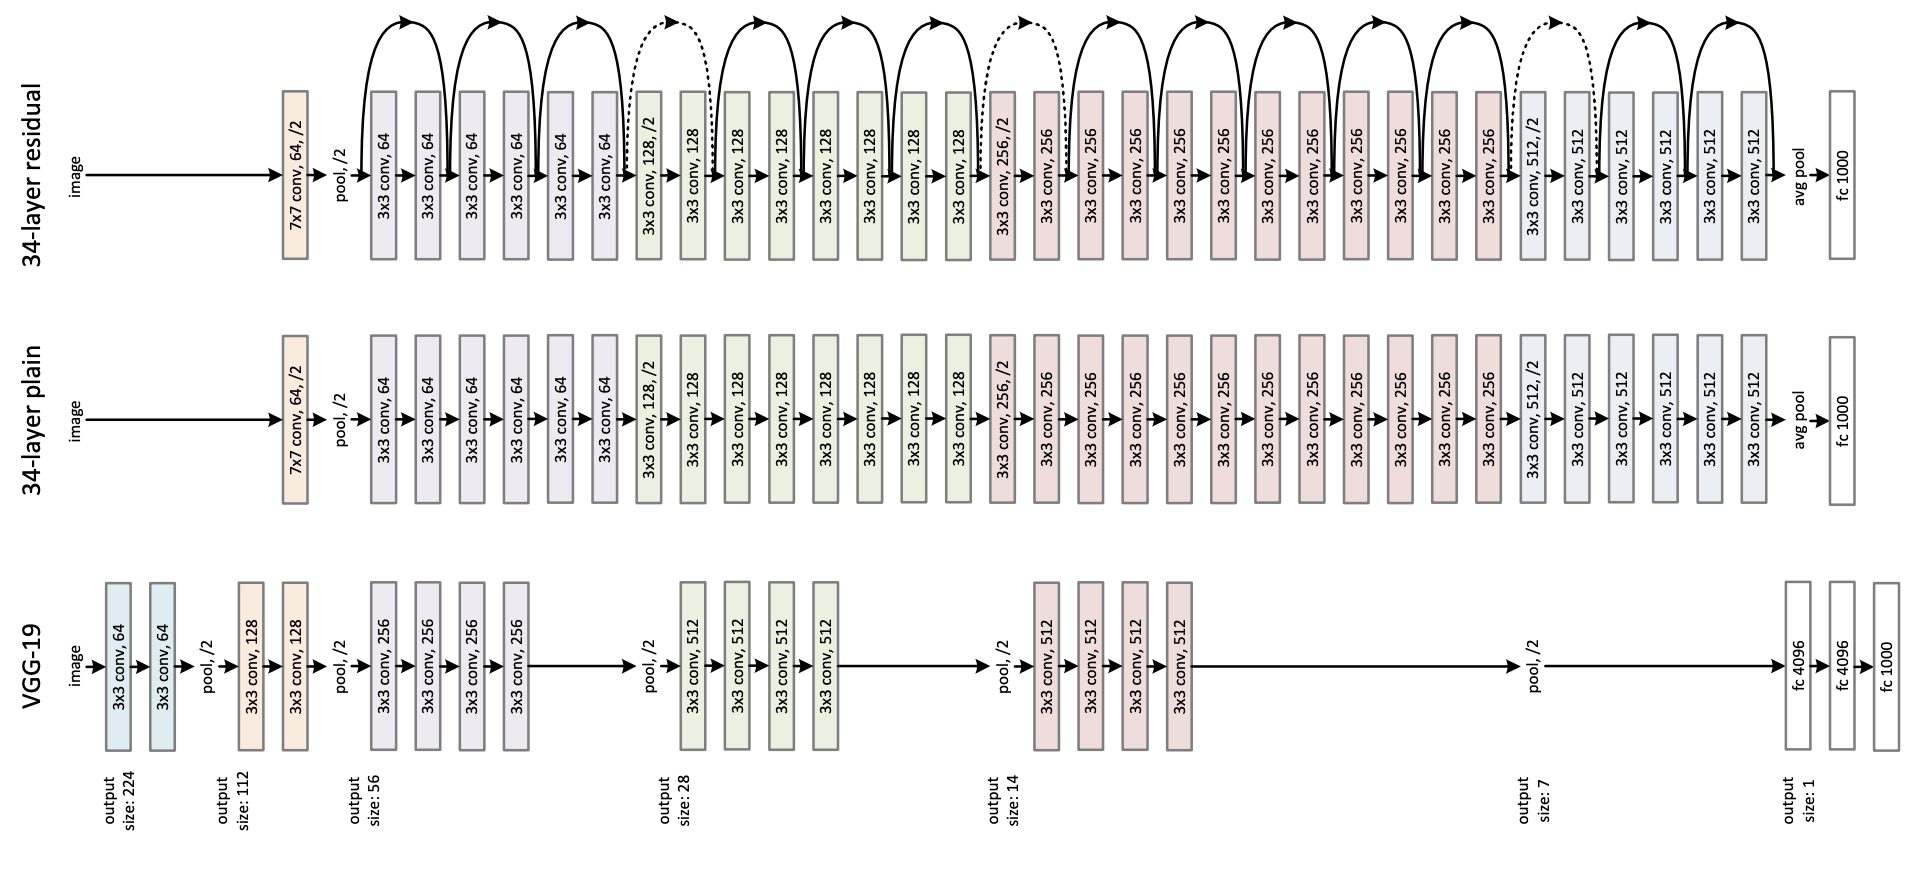

In [6]:
print(model)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [7]:
model = model.eval()  # Poner el modelo en modo de evaluación
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = model.to(device)

Using device: cuda


In [8]:
data_config = timm.data.resolve_model_data_config(model)
transform = timm.data.create_transform(**data_config, is_training=False)

### 1.1 Carga de datos

In [9]:
root_data="/home/v839/v839190/poda/poda efficientnet/data/"


In [10]:
# Define las rutas a los archivos
loc_synset_mapping_path = root_data+'LOC_synset_mapping.txt'
ids_path = root_data+'ids.txt'

# Inicializa un diccionario para el mapeo de Synset ID a Etiqueta Numérica
synset_to_num = {}
# Inicializa un diccionario para el mapeo de Etiqueta Numérica a Descripción Humana
num_to_human = {}

# Leer LOC_synset_mapping.txt y construir ambos mapeos
with open(loc_synset_mapping_path, 'r') as f:
    for index, line in enumerate(f):
        parts = line.strip().split(' ', 1)
        synset_id = parts[0]
        human_readable = parts[1] if len(parts) > 1 else ""

        # Asignar el índice como etiqueta numérica al synset ID
        synset_to_num[synset_id] = index
        # Asignar la descripción humana a la etiqueta numérica
        num_to_human[index] = human_readable

# Opcionalmente, imprime los primeros elementos de cada mapeo para verificar
print("Synset to Numeric Label Mapping (sample):", list(synset_to_num.items())[:5])
print("Numeric Label to Human-readable Mapping (sample):", list(num_to_human.items())[:5])

# Si necesitas el mapeo inverso de etiquetas numéricas a Synset IDs (por ejemplo, para usar con ids.txt),
# puedes invertir el diccionario synset_to_num así:
num_to_synset = {v: k for k, v in synset_to_num.items()}

Synset to Numeric Label Mapping (sample): [('n01440764', 0), ('n01443537', 1), ('n01484850', 2), ('n01491361', 3), ('n01494475', 4)]
Numeric Label to Human-readable Mapping (sample): [(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


In [11]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataset, synset_to_num):
        self.dataset = dataset
        self.synset_to_num = synset_to_num
        # Invertir el mapeo de clase a índice de ImageFolder para obtener Synset IDs a partir de etiquetas de ImageFolder
        self.idx_to_synset = {v: k for k, v in self.dataset.class_to_idx.items()}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        # Convertir la etiqueta de ImageFolder a Synset ID y luego a tu etiqueta numérica personalizada
        synset_id = self.idx_to_synset[label]
        custom_label = self.synset_to_num[synset_id]
        return img, custom_label


In [12]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Función para obtener los logits y etiquetas en formato legible
def get_predictions_and_labels(data_loader, model):
    model.eval()  # Asegurarse de que el modelo está en modo evaluación
    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for images, labels in data_loader:
            images = images.to(model.device)
            labels = labels.to(model.device)
            outputs = model(images)
            logits = outputs.logits
            return logits, labels, images  # Usa return aquí para solo procesar un batch

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

# Función para obtener los logits y las etiquetas asociadas en un DataFrame
def logits_to_dataframe(logits, num_to_human):
    logits_array = logits.cpu().numpy()  # Convertir los logits a un array de numpy
    # Crear un DataFrame con los logits y las etiquetas humanas correspondientes
    data = {
        'Logit': logits_array,
        'Label': [num_to_human[i] for i in range(len(logits_array))]
    }
    df = pd.DataFrame(data)
    df.sort_values(by='Logit', ascending=False, inplace=True)  # Ordenar por logits, de mayor a menor
    return df

# Función para visualizar una imagen junto con su DataFrame de logits
def visualize_image_with_logits(image, logits, num_to_human):
    # Visualizar la imagen
    plt.figure(figsize=(5, 5))
    img = image.cpu().numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5  # Desnormalizar
    plt.imshow(np.clip(img, 0, 1))
    plt.axis('off')
    plt.show()

    # Obtener el DataFrame de logits
    df = logits_to_dataframe(logits, num_to_human)
    return df

In [14]:
import numpy as np
from PIL import Image
# Variable global para el contador de imágenes
image_counter = 0

# def generate_image_from_variables(variables):
#     global image_counter
#     image_counter += 1

#     # Asumimos que 'variables' es un array de numpy con tamaño 150528 (224*224*3)
#     # Primero, se debe verificar si el tamaño del array es el correcto
#     if len(variables) != 224 * 224 * 3:
#         raise ValueError("El número de variables proporcionado no es correcto para una imagen de 224x224 con 3 canales RGB")

#     # Reorganizamos el array para que tenga la forma (224, 224, 3)
#     # La forma indica que hay 224 filas, 224 columnas, y 3 canales (RGB)
#     image_array = variables.reshape((224, 224, 3))

#     # Aseguramos que los datos estén en el rango correcto [0, 255] y sean enteros
#     image_array = np.clip(image_array, 0, 255).astype(np.uint8)

#     # Creamos una imagen usando PIL y el array
#     image = Image.fromarray(image_array, 'RGB')

#     # Ahora la imagen puede ser mostrada o guardada en un archivo
#     # image.show() # Descomentar para mostrar la imagen
#     if image_counter % 5000 == 0 or image_counter == 0:
#             image_path = f"imagenes/image_{image_counter}.png"  # Definir la ruta del archivo
#             image.save(image_path)  # Guardar la imagen en el archivo
#             print(f"Image saved: {image_path}")  # Opcional: imprimir la ruta de la imagen guardada

#     return image

In [15]:
import numpy as np
from PIL import Image

global image_counter
image_counter = 0

def generate_image_from_variables(variables):
    global image_counter
    image_counter += 1

    num_variables = len(variables)
    # Determinar el número de canales basado en la divisibilidad por 3
    if num_variables % 3 == 0:
        # Configuración para 3 canales (RGB)
        num_channels = 3
        num_pixels = num_variables // num_channels
        image_mode = 'RGB'
    else:
        # Configuración para 1 canal (escala de grises)
        num_channels = 1
        num_pixels = num_variables // num_channels
        image_mode = 'L'

    image_side_length = int(np.sqrt(num_pixels))
    if image_side_length**2 != num_pixels:
        raise ValueError("El número de variables no permite una configuración cuadrada de píxeles.")

    # Reorganizar el array para que tenga la forma correcta según el número de canales
    image_array = variables.reshape((image_side_length, image_side_length, num_channels))

    # Asegurar que los datos estén en el rango correcto [0, 255] y sean enteros
    image_array = np.clip(image_array, 0, 255).astype(np.uint8)

    # Crear una imagen usando PIL y el array
    image = Image.fromarray(image_array.squeeze(), image_mode)  # .squeeze() elimina dimensiones de tamaño 1

    # Guardar la imagen cada 5000 iteraciones o en la primera iteración
    if image_counter % 5000 == 0 or image_counter == 1:
        image_path = f"imagenes/image_{image_counter}.png"  # Definir la ruta del archivo
        image.save(image_path)  # Guardar la imagen en el archivo
        print(f"Image saved: {image_path}")  # Opcional: imprimir la ruta de la imagen guardada

    return image



In [16]:
import pandas as pd
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_tensor
from PIL import Image

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Inicializa un contador global
image_display_counter = 0

import os



def wrapped_fitness_function(variables):
# Generar la imagen desde el vector de variables
    pil_image = generate_image_from_variables(variables)

    # Transformar la imagen para el modelo
    image_tensor = transform(pil_image).unsqueeze(0).to(model.device)

    # Obtener logits del modelo
    model.eval()
    with torch.no_grad():
        logits = model(image_tensor).logits.squeeze()  # Asegurarse de que el tensor está bien dimensionado

    # Convertir logits a DataFrame para buscar fácilmente la clase 'tiger'
    logits_df = pd.DataFrame({
        'logit': logits.cpu().numpy(),
        'label': [num_to_human[idx] for idx in range(len(logits))]
    })

    # Buscar el logit de la clase 'tiger'
    # Asumiendo que 'tiger' podría no estar directamente en el string, buscamos subcadenas
    tiger_row = logits_df[logits_df['label'].str.contains('tiger', case=False, regex=True)]
    if not tiger_row.empty:
        tiger_logit = tiger_row['logit'].iloc[0]
    else:
        print("Tiger class not found, returning a high negative value to handle error.")
        tiger_logit = -1000  # Un valor muy negativo para manejar el caso de que 'tiger' no esté presente

    # Devolver el negativo del logit de "tiger" como valor de fitness
    return -tiger_logit




def convert_to_rgb(image):
    if image.mode != 'RGB':
        return image.convert('RGB')
    return image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(convert_to_rgb),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:
import EDAspy2
from EDAspy2.optimization import UMDAc
from EDAspy2.optimization import EGNA

In [18]:
# def generate_black_list(num_pixels_per_channel=128*128, num_channels=3):
#     black_list = []
#     white_list = set()  # Usamos un conjunto para la white_list para evitar duplicados

#     # Generar los índices para cada canal
#     for i in range(num_pixels_per_channel):
#         current_pixel_indices = [i + j * num_pixels_per_channel for j in range(num_channels)]
        
#         # Añadir a la white_list las relaciones permitidas (mismo píxel, diferentes canales)
#         for c1 in range(num_channels):
#             for c2 in range(c1 + 1, num_channels):
#                 white_list.add((current_pixel_indices[c1], current_pixel_indices[c2]))
#                 white_list.add((current_pixel_indices[c2], current_pixel_indices[c1]))

#         # Añadir a la black_list las relaciones prohibidas
#         for c1 in range(num_channels):
#             for c2 in range(num_channels):
#                 if c1 != c2:
#                     for j in range(num_pixels_per_channel):
#                         if i != j:  # Evitar añadir el mismo pixel en diferentes canales a la black_list
#                             black_list.append((current_pixel_indices[c1], j + c2 * num_pixels_per_channel))

#     # Remover de la black_list cualquier par que está en la white_list
#     final_black_list = [pair for pair in black_list if pair not in white_list]

#     return final_black_list

# # Utiliza esta función para obtener tu black_list
# black_list = generate_black_list()


In [19]:
# # Configuración de EGNA
# EGNA = EGNA(
#     size_gen=25,
#     max_iter=300,
#     dead_iter=10,
#     n_variables=224*224*3,
#     lower_bound=0,
#     upper_bound=255,
#     alpha=0.5)

In [1]:
from EDAspy2.optimization import UMDAc
from EDAspy2.optimization import EGNA
# Configuración de EGNA
egna = EGNA(
    size_gen=25,
    max_iter=300,
    dead_iter=10,
    n_variables=224*224,
    lower_bound=0,
    upper_bound=255,
    alpha=0.5)

In [4]:
print(egna)
egna.print_parameters()

Display: True
Generation Size: 25
Max Iterations: 300
Alpha: 0.5
Number of Variables: 50176
Truncation Length: 12
Elite Factor: 0.4
Elite Length: 10
Parallelization: False
Dead Iterations: 10
Tolerance: 0.001
Initial Data Provided: No


In [21]:
best_solution = egna.minimize(wrapped_fitness_function)

Image saved: imagenes/image_1.png
IT:  0 	Best cost:  4.991117
